# Computación Bio-inspirada. Bloque II: Machine Learning. 
# 15 Multi-objective correlation-based feature selection con algoritmos evolutivos multi-objetivo (pymoo) 

Santiago Méndez García (s.mendezgarcia@um.es), Domingo Méndez García (domingo.mendezg@um.es)

Computación Bio-inspirada. Máster en Inteligencia Artificial. Universidad de Murcia. Curso 2024/2025.

## 1. Objetivos y metodología

Diseñar un AE como estrategia de búsqueda del método correlation-based feature
selection (Tema 5, pág. 11) pero usando el enfoque multi-objetivo propuesto en el Tema
5, pág. 13. Implementar el AE con representación binaria, selección
por ranking exponencial (c = 0.3), muestreo estocástico con reemplazo, sustitución
generacional completa, cruce uniforme (𝑝𝑝𝑐𝑐 = 0.6), mutación bit-flip (𝑝𝑝𝑚𝑚 = 0.1) y
100000 evaluaciones de la función objetivo. Ejecutar el AE 10 veces con diferente
semilla para el conjunto de datos ALL-AML_train 5 . Visualizar gráficamente la
evolución del algoritmo (10 runs sobre el mismo gráfico). Reportar la siguiente tabla
de resultados:

| Seed | HV | ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|------|---------|-----------------------|------------------------|------------------------|----------------------|-----------------------|-----------------------|
| 1    |         |                       |                        |                        |                      |                       |                       |
| 2    |         |                       |                        |                        |                      |                       |                       |
| ...  |         |                       |                        |                        |                      |                       |                       |
| 10   |         |                       |                        |                        |                      |                       |                       |
| Mejor   |     |                       |                        |                        |                      |                       |                       |
| Peor    |     |                       |                        |                        |                      |                       |                       |
| Promedio |   |                       |                        |                        |                      |                       |                       |
| Desv. Tip. |  |                       |                        |                        |                      |                       |                       |


Para RF, SVM y MLP usar sklearn.ensemble.RandomForestClassifier,
sklearn.svm.SVC y sklearn.neural_network, respectivamente con los hiperparámetros por defecto. Por otro lado, reportar la siguiente tabla:

| Todos los atributos |                        |                        |                        |                       |                       |                       |
|---------------------|------------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|
| ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|                      |                        |                        |                       |                       |                       |

En la primera tabla reportada, cambiar fitness por HV (hipervolumen) y el
resto de los resultados se corresponderán con los de la mejor solución no-dominada
identificada por el MOEA. Consideramos la mejor solución no dominada como, para cada modelo de ML, la solución no dominada de la población obtenida por el MOEA que obtenga mejor métrica accuracy en validación.

### Requerimientos

A continuación se importan las librerías de _Python_ necesarias, se establece la semilla de _Numpy_ para la reproducibilidad y se definen la ruta del directorio donde se guardarán los resultados y algunas variables que se pueden utilizar para hacer pruebas de menor tamaño o utilizar los resultados ya guardados.

In [1]:
# === Bibliotecas estándar de Python ===
import os # crear y leer archivos
import sys
import time # tiempos de ejecución
import copy # copia profunda de objetos (callback pymoo)
import random
import pickle # guardar y cargar objetos
import warnings
import pkg_resources

# === Utilidades para notebooks ===
from IPython.display import display, HTML

# === Bibliotecas científicas ===
import numpy as np                           # Vectores y matrices
import pandas as pd                          # Dataframes
import matplotlib.pyplot as plt              # Gráficos
from scipy.io import arff                    # Lectura de archivos .arff (Weka)
from scipy.stats import pointbiserialr       # Correlación punto-biserial

# === Scikit-learn: ML y procesamiento ===
from sklearn.preprocessing import LabelEncoder            # Codificación de variables categóricas
from sklearn.impute import SimpleImputer                  # Imputación de valores faltantes
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)      # División y validación cruzada
from sklearn.exceptions import ConvergenceWarning          # Manejador de warnings

# == modelos para la práctica ==

from sklearn.ensemble import RandomForestClassifier        # Clasificador de Bosques Aleatorios
from sklearn.svm import SVC                                # Clasificador de Vectores de Soporte
from sklearn.neural_network import MLPClassifier           # Perceptrón multicapa

# === Pymoo: Optimización multiobjetivo evolutiva ===
import pymoo                                               # Framework de optimización multiobjetivo

# Algoritmos evolutivos
from pymoo.algorithms.moo.nsga2 import NSGA2               # Algoritmo NSGA-II

# Problemas y núcleo

from pymoo.core.problem import ElementwiseProblem          # Definición del problema multiobjetivo

# Terminación y optimización
from pymoo.optimize import minimize                        # Función principal de optimización
from pymoo.termination import get_termination              # Criterios de parada

# Visualización de resultados
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter            # Dispersión de soluciones
from pymoo.visualization.pcp import PCP                    # Parallel Coordinate Plot

# Métricas de calidad
from pymoo.indicators.gd import GD                         # Generational Distance
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD                       # Inverted GD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV                         # Hypervolume

# Operadores evolutivos
from pymoo.operators.crossover.ux import UniformCrossover  # Cruce uniforme (binario)
from pymoo.operators.mutation.bitflip import BitflipMutation  # Mutación bitflip
from pymoo.operators.sampling.rnd import (Sampling,
                                          BinaryRandomSampling)  # Muestreo aleatorio binario

# Utilidades adicionales de pymoo
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting  # Ordenación por no dominación
from pymoo.core.callback import Callback                   # Callbacks para guardar resultados por generación
from pymoo.core.selection import Selection                 # Clase base para selección

# === Warnings (desactivación de advertencias) ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter("ignore", category=UserWarning)


profiling = False # Poner a True para hacer profiling
LEVEL = 3 # Tamaño de profiling (1: bajo, 2: medio, 3: alto)

DATASET_NAME = '../DATASETS/ALL-AML' # Atributos numéricos y categóricos
DATASET_TRAIN_PATH = DATASET_NAME + '_train.arff' # Ruta del archivo de entrenamiento
DATASET_TEST_PATH = DATASET_NAME + '_test.arff' # Ruta del archivo de prueba

RESULTS_DIR = 'cbio_p15_results' if not profiling else 'cbio_p15_results_profiling' # Directorio de resultados

DONE = False # Poner a True para ejecutar los algoritmos y entrenamientos
LOAD = DONE # Cargar resultados de pruebas anteriores
DEBUG = False # Poner a True para verbose

SEED = 2025
np.random.seed(SEED)   # Establecer semilla
random.seed(SEED) # Establecer semilla

/tmp/ipykernel_515965/86343147.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
# Reportar versiones de las librerías

# Obtenemos la versión de Python
version_python = sys.version

# Crear contenido HTML para mostrar en el notebook
html_content = f"""
<table>
    <tr><th>Python Version</th></tr>
    <tr><td>{version_python}</td></tr>
</table>
"""

# Mostrar la versión de Python en el notebook
display(HTML(html_content))

# Obtenemos la versión de las librerías

# Define la lista de librerías que deseas verificar
librerias_interes = [
"ipython",
"landscapes",
"matplotlib",
"numpy",
"pandas",
"scipy",
"sklearn",
"tqdm",
"pymoo",
"pyswarms",
]
# Crear una lista con las versiones de las librerías de interés
versiones = []
for lib in librerias_interes:
    try:
        version = pkg_resources.get_distribution(lib).version
        versiones.append((lib, version))
    except pkg_resources.DistributionNotFound:
        versiones.append((lib, "No instalada"))

# Generar una tabla en HTML para mostrar en el notebook
html_content = "<table>"
html_content += "<tr><th>Library</th><th>Version</th></tr>"
for package_name, version in versiones:
    html_content += f"<tr><td>{package_name}</td><td>{version}</td></tr>"
html_content += "</table>"

# Mostrar la tabla en el notebook
display(HTML(html_content))

### Cargar Dataset

In [3]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns
    
    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    # Aplicar hot encoding
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])
        X = pd.get_dummies(data=df.iloc[:, :-1], columns=categorical_attributes)    
        X = X.astype(float)
    else:
        X = df.iloc[:, :-1]    
    
    # Salida: y
    y = [label.decode('utf-8') for label in df.iloc[:, -1]]
    class_values = meta[meta.names()[-1]][1]  # Obtiene los valores posibles de la clase 
    le = LabelEncoder() # para codificar la clase binaria
    le.fit(class_values)
    y = le.transform(y)
    y = y.astype(np.int32)

    return X,y

In [4]:
def summarize_arff(file_path):
    """
    Summarizes an ARFF dataset by providing the number of rows, features, 
    data types, and basic statistics for numerical features.
    
    Args:
        file_path (str): Path to the ARFF file.
    """
    # Load the ARFF file
    data, meta = arff.loadarff(file_path)
    
    # Convert to a Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Display basic information
    print(f"Dataset Summary for: {file_path}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    print("\nFeature Types:")
    print(df.dtypes)
    
    # Separate numerical and categorical features
    numeric_features = df.select_dtypes(include=['int64', 'float64'])
    categorical_features = df.select_dtypes(include=['object'])
    
    # Count nans in all features
    nan_counts = df.isnull().sum().sum()
    print(f"\nNaN Counts:{nan_counts}")
    
    # Display unique values for categorical features
    if not categorical_features.empty:
        print("\nCategorical Features Unique Values:")
        for col in categorical_features.columns:
            print(f"{col}: {df[col].nunique()} unique values")

In [5]:
summarize_arff(DATASET_TRAIN_PATH)

Dataset Summary for: ../DATASETS/ALL-AML_train.arff
Number of rows: 38
Number of features: 7130

Feature Types:
attribute1       float64
attribute2       float64
attribute3       float64
attribute4       float64
attribute5       float64
                  ...   
attribute7126    float64
attribute7127    float64
attribute7128    float64
attribute7129    float64
myclass           object
Length: 7130, dtype: object

NaN Counts:0

Categorical Features Unique Values:
myclass: 2 unique values


El dataset de train, ALL-AML_train, tiene 38 filas y 7130 columnas, de las cuales 7129 son atributos predictores numéricos y 1 es el target, que es una etiqueta binaria.

In [6]:
X_train,y_train = LoadData(DATASET_TRAIN_PATH)
X_test,y_test = LoadData(DATASET_TEST_PATH)

K = 4 if not profiling else 2
cv = RepeatedStratifiedKFold(n_splits=K, n_repeats=2, random_state=SEED)

Cargamos los datasets de train y test y generamos una partición de crosvalidación estratificada para la validación de los modelos de ML.

In [7]:
print(f"Test dataset shape: {X_test.shape}")

Test dataset shape: (34, 7129)


El dataset de test tiene 34 ejemplos.

In [8]:
n_features = X_train.shape[1]

print(f"Train dataset shape: {X_train.shape}")

Train dataset shape: (38, 7129)


In [9]:
# Number of target classes
n_classes = len(np.unique(y_train))
print(f"Number of classes: {n_classes}")

Number of classes: 2


### Análisis exploratorio: correlación entre atributos

El problema de selección de atributos basado en correlación utiliza la correlación entre atributos para calcular una medida de evaluación de subconjuntos de atributos. Conviene analizar tanto la correlación entre los atributos y el target como la correlación de los pares de atributos entre sí. Así podremos ver cómo es nuestra instancia del problema, en particular si hay muchos atributos relevantes o redundantes, y esto nos servirá para analizar los resultados obtenidos más tarde.

In [10]:
# Correlations between features and target
correlations = []
for i in range(n_features):
    corr, _ = pointbiserialr(X_train.iloc[:, i], y_train)
    correlations.append((i, abs(corr)))
correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
print("Top 10 features by correlation with target:")
for i, corr in correlations[:10]:
    print(f"Feature {i}: {corr:.4f}")

Top 10 features by correlation with target:
Feature 3319: 0.8283
Feature 4846: 0.8223
Feature 2019: 0.8112
Feature 1744: 0.7768
Feature 5038: 0.7765
Feature 1833: 0.7707
Feature 460: 0.7578
Feature 4195: 0.7495
Feature 3846: 0.7471
Feature 2287: 0.7435


Analizamos la correlación entre las features predictoras y el objetivo. Aquí vemos el top 10 de features más correlacionadas con el objetivo, siendo la primera el atributo 3319 con una correlación absoluta de 0.8283. Los 10 tienen una correlación absoluta superior a 0.7.

In [11]:
# Correlation stats
df_corr_abs = pd.DataFrame(correlations, columns=['Feature', 'Abs Correlation'])
print("Estadísticas de la correlación absoluta:")
display(df_corr_abs['Abs Correlation'].describe())

print(f"{len(df_corr_abs[df_corr_abs['Abs Correlation'] > 0.5])/len(df_corr_abs)*100:.2f}% de los atributos tienen correlación absoluta > 0.5")


Estadísticas de la correlación absoluta:


count    7129.000000
mean        0.211047
std         0.149972
min         0.000066
25%         0.087310
50%         0.184025
75%         0.309132
max         0.828290
Name: Abs Correlation, dtype: float64

4.61% de los atributos tienen correlación absoluta > 0.5


La correlación absoluta media es bastante alta: 0.21, y el 4.61% de los atributos tienen una correlación absoluta superior a 0.5 con el target. Seleccionar los atributos con mayor correlación puede ser clave para conseguir un buen modelo con pocos atributos.

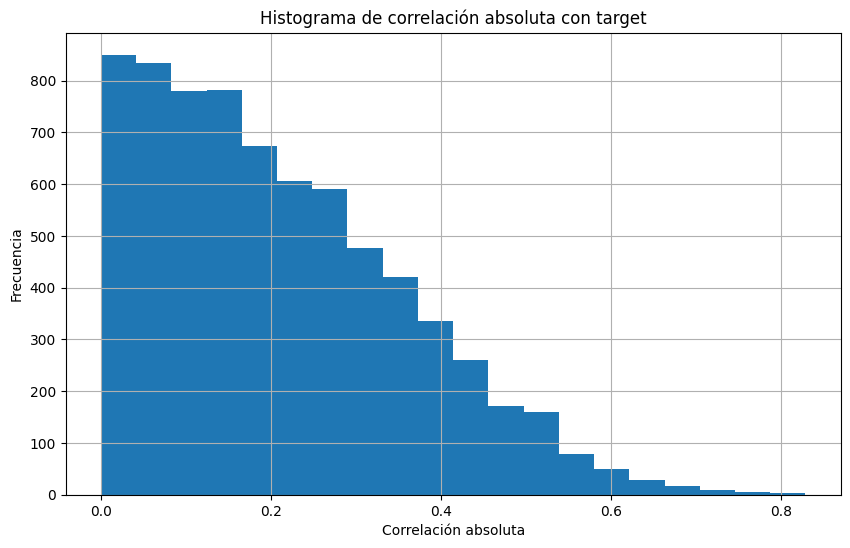

In [12]:
plt.figure(figsize=(10, 6))
plt.title("Histograma de correlación absoluta con target")
df_corr_abs['Abs Correlation'].hist(bins=20)
plt.xlabel("Correlación absoluta")
plt.ylabel("Frecuencia")
plt.show()

Vemos el histograma de correlación absoluta de las features con el target. Un 25% se sitúan por encima de 0.2.

Ahora analizamos la correlación entre los atributos.

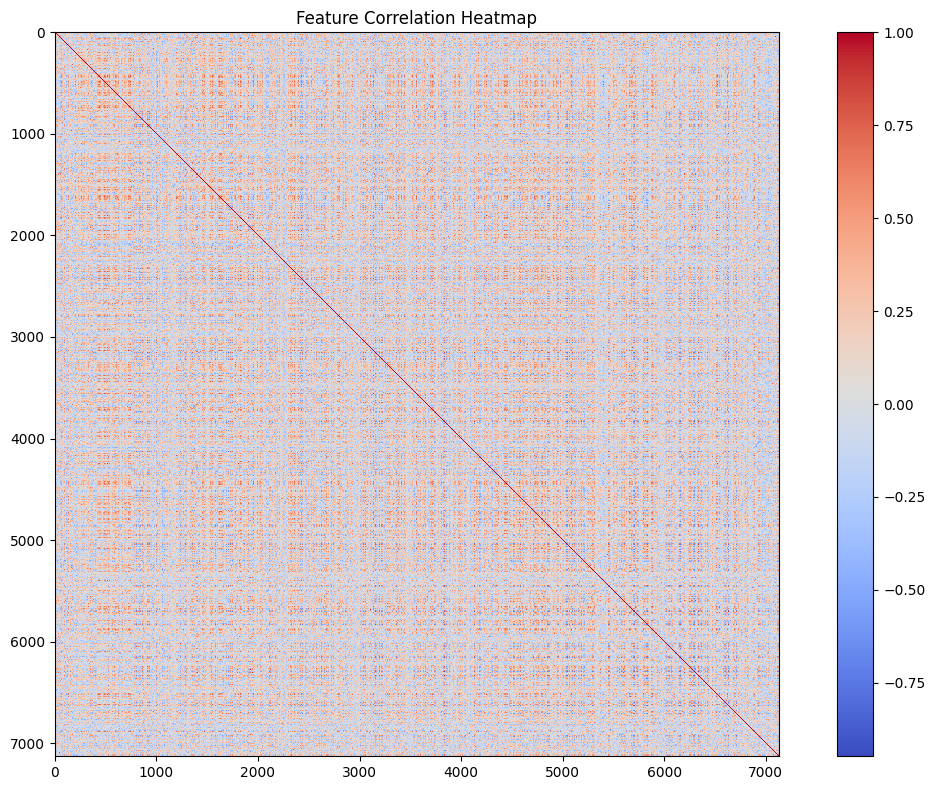

In [13]:
# Correlation heatmap
Xy_train = pd.concat([X_train, pd.Series(y_train)], axis=1)

plt.figure(figsize=(12, 8))
plt.title("Feature Correlation Heatmap")
plt.imshow(Xy_train.corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.tight_layout()
plt.show()

Hay tantos atributos que el heatmap no es interpretable, hay una variedad de correlaciones positivas y negativas entre atributos pero dado el tamaño del dataset no podemos cuantificarlas así. Veamos un resumen estadístico de estas correlaciones.

In [14]:
# Obtener 10 máximas correlaciones entre features en X_train

def get_top_correlations(X, n=10):
    """
    Get the top n correlations between features in a DataFrame.
    
    Args:
        X (pd.DataFrame): DataFrame containing features.
        n (int): Number of top correlations to return.
        
    Returns:
        pd.DataFrame: DataFrame with top n correlations.
    """
    corr_matrix = X.corr().abs()
    corr_matrix.values[np.tril_indices_from(corr_matrix, k=0)] = 0  # Set lower triangle to 0 to ignore duplicates
    
    corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
    top_corr = corr_pairs[corr_pairs < 1].head(n)
    
    return top_corr, corr_matrix

top_correlations_df, corr_matrix = get_top_correlations(X_train, n=10)
print("Top 10 feature correlations:")
display(top_correlations_df)

Top 10 feature correlations:


attribute5987  attribute5986    0.994882
attribute6183  attribute6182    0.994788
attribute6088  attribute5449    0.992730
attribute6803  attribute6797    0.991816
attribute6806  attribute6803    0.989830
attribute6201  attribute6200    0.989570
attribute7093  attribute7066    0.988301
attribute5071  attribute990     0.985045
attribute5599  attribute5376    0.984873
attribute6806  attribute6797    0.982710
dtype: float64

En el top 10 de correlaciones absolutas de atributos todas son superiores al 98%. Hay columnas redundantes en el dataset, que seguramente convendrá filtrar en la selección de atributos porque no aportarán nueva información al modelo.

In [15]:
# Summarize the correlation matrix
def summarize_correlation_matrix(corr_matrix):
    """
    Summarizes the correlation matrix by providing mean, std, min, and max values.
    
    Args:
        corr_matrix (pd.DataFrame): Correlation matrix.
        
    Returns:
        dict: Summary statistics of the correlation matrix.
    """
    # Select upper triangle of the correlation matrix
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    feature_corr_vals = pd.DataFrame(corr_matrix.values[upper_triangle], columns=['Correlation'])
    display(feature_corr_vals.describe())
    return feature_corr_vals

print("Feature correlation matrix summary:")
feature_corr_vals = summarize_correlation_matrix(corr_matrix)

Feature correlation matrix summary:


Correlation
count  2.540776e+07
mean   1.905240e-01
std    1.457169e-01
min    0.000000e+00
25%    7.495071e-02
50%    1.591899e-01
75%    2.743225e-01
max    9.948823e-01

Arriba imprimimos un resumen estadístico de los valores de correlación absoluta de los pares de atributos distintos. La correlación absoluta media es casi 0.2. Hay una gran parte de atributos con muy baja correlación, el 25% de los pares tienen menos de 0.075. El 25% tienen más de 0.274. La redundancia no es despreciable y antes hemos visto una alta relevancia de buena cantidad de atributos, así que esperamos que los subconjuntos de atributos seleccionados obtenidos puedan ser a la vez pequeños y con alto score de correlación.

## 2. Problema del Multi-objective correlation-based feature selection 

El problema de la selección de atributos (SA), o *feature selection*, en Machine Learning (ML) se trata de, dado un dataset, seleccionar el subconjunto de atributos mínimo más "relevante" o "útil" para la tarea de predicción. Las principales razonas para aplicar SA son reducir el tiempo de entrenamiento y/o la complejidad del modelo, evitando overfitting y facilitando la interpretabilidad, incluso en ocasiones mejorando la precisión del modelo. Dependiendo del enfoque utilizado, la relevancia o utilidad del subconjunto de atributos puede medirse de distintas formas, dando lugar a distintos tipos de SA. Los problemas de SA se pueden clasificar principalmente en:

-  **Evaluación de atributos** o feature ranking: evalúan los atributos individualmente.
-  **Evaluación de subconjuntos de atributos**: evalúan subconjuntos sucesivos de atributos generados por una estrategia de búsqueda.

Los métodos de SA están íntimamente ligados con el tipo de problema, y se pueden clasificar en:

-  **Wrapper**: la función objetivo es el rendimiento del modelo de ML, con la métrica de evaluación adecuada sobre un conjunto de validación. En clasificación puede usarse el accuracy.
-  **Integrado**: modelos que realizan la selección de atributos como parte del proceso de entrenamiento. Por ejemplo, árboles de decisión o regresión Lasso.
-  **Filtro**: separa la selección de atributos del algoritmo de aprendizaje. El subconjunto de atributos se escoge optimizando alguna medida estadística de información.

En nuestro caso la tarea de predicción es la clasificación binaria, y el dataset tiene un gran número de atributos (7138) que la SA pretende reducir. Consideraremos la SA como un problema de evaluación de subconjuntos de atributos y lo resolveremos con un métodos filtro (seleccionar antes de entrenar). Vamos a considerar el problema de la evaluación de subconjuntos de atributos como un problema de optimización combinatoria booleana multiobjetivo: por un lado, queremos minimizar el número de atributos seleccionados; por otro, queremos maximizar una métrica de correlación entre los atributos seleccionados y el target. Para resolverlo usaremos un algoritmo evolutivo multiobjetivo (MOEA) como estrategia de búsqueda, en concreto, será NSGA-II.

A continuación, describimos la formulación del problema de optimización multiobjetivo que representa la selección de atributos.

Sea $m = 7129$ el número de atributos de nuestro dataset. Las variables de decisión del problema son $x_l \in \{0,1\}, l= 1, \ldots, m$, que representan la selección o no de los atributos, de la siguiente forma:

$$ \forall l = 1, 2, \ldots, m, \qquad x_l = 
\begin{cases} 
1 & \text{si el atributo } l \text{ es seleccionado}, \\
0 & \text{si el atributo } l \text{ no es seleccionado}.
\end{cases}$$

El primer objetivo es minimizar el número de atributos seleccionados. En nuestro hemos utilizado la proporción de atributos seleccionados respecto al total de atributos para normalizarla entre 0 y 1:

$$\operatorname{Minimizar} f_1(x) = \frac{1}{m} \sum_{l=1}^m x_l.$$

El segundo objetivo es el correlation-based feature selection merit score (Hall, 1999), que es una medida de compromiso entre la relevancia y la redundancia de los atributos seleccionados. Se define como:

$$\operatorname{Maximizar} f_2(x) =
\frac{\mathcal{C}(x) \cdot \sigma_{D}^{C}(x)}
{\sqrt{\mathcal{C}(x)+\mathcal{C}(x)\cdot(\mathcal{C}(x)-1)\cdot \sigma_{D}^{f}(x)}},$$

donde:
- $x = (x_1, x_2, \ldots, x_m)$ es el vector de variables de decisión.
- $\mathcal{C}(x) = \sum_{l=1}^m x_l$ es la cardinalidad del subconjunto de atributos seleccionados.
- $D$ es el dataset con $m$ atributos de entrada.
- $\sigma_{D}^{C}(x)$ es la correlación absoluta promedio entre cada atributo seleccionado en $x$ y el target.
- $\sigma_{D}^{f}(x)$ es la correlación absoluta promedio entre cada par de atributos seleccionados en $x$, de los $\binom{\mathcal{C}(x)}{2}$ posibles.

El numerador indica la capacidad predictiva (relevancia) del subconjunto de atributos seleccionados, mientras que el denominador indica la redundancia entre esos atributos.

Además, en nuestra implementación hemos añadido la siguiente restricción:

$$s. t. \qquad \mathcal{C}(x) \geq 2$$

ya que si una solución no selecciona al menos 1 atributo, no se puede construir el modelo clasificador, y si no selecciona al menos 2 no se puede calcular el merit score.

Observamos que el rango de las funciones objetivo es:

$$ f_1(x) \in [0, 1] \qquad \text{y} \qquad f_2(x) \in [0, -\sqrt{m}]. $$

$f_1$ es la proporción de atributos seleccionados, que está acotada en $[0, 1]$. En cuanto a $f_2$, es un valor positivo, ya que como las correlaciones se toman en valor absoluto, todos los valores de la fracción son mayores o iguales que 0. El valor máximo se alcanza cuando el numerador es máximo y el denominador mínimo. En el numerador la correlación está acotada por 1: $\sigma_{D}^{C}(x) \leq 1$ y $\mathcal{C}(x) \leq m$, así que está acotado por $\mathcal{C}(x) \leq m$. En el denominador, al suprimir los casos $\mathcal{C}(x)<2$, la cota mínima se da cuando la correlación entre atributos es 0: $\sigma_{D}^{f}(x) = 0$. En este caso, el denominador se acota inferiormente por $\sqrt{\mathcal{C}(x)}$. Por lo tanto, tenemos que:

$$ f_2(x) \leq \frac{\mathcal{C}(x)}{\sqrt{\mathcal{C}(x)}} = \sqrt{\mathcal{C}(x)} \leq \sqrt{m} = \sqrt{7129} \approx 84.43$$

Sin embargo, esta cota es improbable que se alcance, porque si se seleccionan muchos atributos serán redundantes y/o no tendrán una alta correlación media con el target. En la práctica $f_2$ será la mayoría de veces menor que 1 y veremos solamente en casos puntuales que hemos obtenido algún valor entre 1 y 2.

## 3. Algoritmo evolutivo multiobjetivo (pymoo)

En esta sección detallamos el diseño de los componentes del algoritmo evolutivo multiobjetivo (MOEA) aplicado al problema de selección de atributos y su implementación mediante la librería *pymoo*.

La librería *pymoo* es una librería de Python para la optimización multiobjetivo y permite implementar algoritmos MOEA y personalizarlos con distintos operadores de selección, cruce, mutación y muestreo inicial. En este caso hemos implementado el algoritmo **NSGA-II** (Nondominated sortid Genetic Algorithm) con los siguientes componentes:

* **Representación**: la representación de las soluciones es binaria. Cada bit representa la selección o no de un atributo como hemos explicado en la sección anterior. La longitud del cromosoma es igual al número de atributos del dataset, $m = 7129$.
* **N=50**: tamaño de la población.
* **G=2000**: número de generaciones. En total se realizarán $N \cdot G = 50 \cdot 2000 = 100000$ evaluaciones de la función objetivo.
* **Selección**: se utiliza la selección por ranking exponencial con $c = 0.3$. Al ser un problema multiobjetivo, no podemos ordenar la población por un único valor de fitness, así que hemos decidido ordenar el ranking primero por no dominancia, y después dentro de cada frente de dominación ordenar decrecientemente por la distancia de crowding. La distancia de crowding mide cómo de cercano es un individuo a sus vecinos del mismo frente, así que al seleccionar los que tienen mayor distancia con sus vecinos intentamos favorecer la diversidad de la población.
* **Muestreo**: se utiliza el muestreo estocástico con reemplazo. En cada generación se seleccionan $N$ individuos de la población para formar la nueva población. Algunos individuos pueden ser seleccionados más de una vez y otros no ser seleccionados. La probabilidad de selección la da el ranking exponencial.
* **Cruce**: se utiliza el cruce uniforme con probabilidad $p_c = 0.6$. El cruce uniforme consiste en generar cada bit del hijo de forma independiente, con probabilidad $p_c$ de que el bit del padre 1 se copie al hijo y $1-p_c$ de que se copie el bit del padre 2.
* **Mutación**: se utiliza la mutación bit-flip con probabilidad $p_m = 0.1$: cada bit del hijo tiene probabilidad $p_m$ de ser mutado, es decir, de cambiar su valor de 0 a 1 o de 1 a 0.
* **Sustitución generacional completa**. Se generan $N$ hijos en cada generación, que sustituyen a los individuos de la anterior. Para garantizar esto, no se aplica eliminación de individuos duplicados que es habitual en NSGA-II.

La documentación de *pymoo* sobre NSGA-II está disponible en https://pymoo.org/algorithms/moo/nsga2.html

### Constantes del algoritmo evolutivo
- $N = pop\_size$: 50 Tamaño de la población
- $G = n\_gen = 2000$: Número de generaciones
- $seed$: Semilla para reproducibilidad

In [16]:
N_EVALUATIONS = 100000

pop_size = 50 if not profiling else 12*LEVEL
n_gen =  N_EVALUATIONS//pop_size if not profiling else 12*LEVEL
seed = SEED

### Definición del problema de optimización multi-objetivo

Implementamos el problema de selección de atributos multiobjetivo basado en correlación. Previamente, definimos dos funciones para calcular las correlaciones:

1. ***getTargetCorrelations***: calcula la correlación absoluta entre cada atributo y el target, devolviendo un vector de tamaño $m$.
2. ***getFeatureCorrelations***: calcula la correlación absoluta entre cada par de atributos, devolviendo una matriz de tamaño $m \times m$. Con la opción *triu=True* se devuelve la parte triangular superior de la matriz, para eliminar los pares de atributos repetidos y la diagonal.

In [17]:
NAN_CONST = 0
def getTargetCorrelations(X, y):
    """
    Calcula las correlaciones entre los atributos y la variable objetivo.
    """
    correlations = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        corr, _ = pointbiserialr(X[:, i], y)
        correlations[i] = abs(corr) # Feature selection: only magnitude matters
    correlations = np.nan_to_num(correlations, nan=NAN_CONST, posinf=NAN_CONST, neginf=NAN_CONST)  # Reemplazar NaN con 0
    return correlations

def getFeatureCorrelations(X, triu = False):
    """
    Calcula las correlaciones entre los atributos.
    """
    x_corr = np.abs(np.corrcoef(X, rowvar=False))
    
    # Tratar NaNs generados cuando un atributo es constante
    x_corr = np.nan_to_num(x_corr, nan=NAN_CONST, posinf=NAN_CONST, neginf=NAN_CONST)  # Reemplazar NaN con 0

    # Poner diagonal a 0
    np.fill_diagonal(x_corr, 0)
    if triu:
        # Poner la parte inferior de la matriz a 0
        # (caso simétrico)
        x_corr = np.triu(x_corr, k=1)
    
    return x_corr

In [18]:
x_corr = getFeatureCorrelations(X_train.values, triu=True)
# print nans
nans = np.isnan(x_corr)
print(f"NaNs in feature correlation matrix: {np.sum(nans)}")
print(f"Negs in feature correlation matrix: {np.sum(x_corr < 0)}")
y_corr = getTargetCorrelations(X_train.values, y_train)
# print nans
nans = np.isnan(y_corr)
print(f"NaNs in target correlation vector: {np.sum(nans)}")
print(f"Negs in feature correlation matrix: {np.sum(y_corr < 0)}")

print(x_corr[:10, :10])

NaNs in feature correlation matrix: 0
Negs in feature correlation matrix: 0
NaNs in target correlation vector: 0
Negs in feature correlation matrix: 0
[[0.         0.40448512 0.12584021 0.10626817 0.29272796 0.31272006
  0.11211397 0.13044582 0.08051244 0.20903199]
 [0.         0.         0.11154144 0.21154333 0.21357687 0.22110001
  0.14846236 0.06258055 0.25153082 0.0732407 ]
 [0.         0.         0.         0.13236261 0.12305274 0.10311344
  0.19020024 0.01562163 0.29182309 0.2293609 ]
 [0.         0.         0.         0.         0.10989979 0.14732549
  0.04221893 0.12335712 0.01726106 0.30985726]
 [0.         0.         0.         0.         0.         0.74370567
  0.17381198 0.59140091 0.38041424 0.12712836]
 [0.         0.         0.         0.         0.         0.
  0.00988818 0.66882474 0.31445118 0.13890302]
 [0.         0.         0.         0.         0.         0.
  0.         0.05359021 0.05697414 0.2666612 ]
 [0.         0.         0.         0.         0.         0.


Hemos implementado el problema de selección de atributos multiobjetivo basado en correlación, descrito en la sección 2, como una clase que hereda de la clase *ElementwiseProblem* de *pymoo*. Esta clase debe redefinir los siguientes métodos:

* ***__init__***: inicializa el problema, con 2 objetivos, $m$ variables de decisión binarias y 1 restricción. Además se pasa como parámetro el dataset etiquetado **(X,y)**, con el que calculamos las matrices de correlación (*getTargetCorrelations* y *getFeatureCorrelations*) para calcular *f2* posteriormente.
* ***_evaluate***: evalúa la función objetivo y la restricción para un individuo $x$. La función objetivo es un vector $(f_1, f_2)$. La restricción $\sum_{l=1}^{m}{x_l} \geq 2$ se guarda con un valor $g$ que es menor o igual que 0 si y solo si se cumple la restricción. Vamos a implementar el problema como una minimización, así que hemos cambiado el signo a $f_2$ respecto a lo explicado en la sección 2. Ahora tenemos que $f_2(x) = -1 \times
\frac{\mathcal{C}(x) \cdot \sigma_{D}^{C}(x)}
{\sqrt{\mathcal{C}(x)+\mathcal{C}(x)\cdot(\mathcal{C}(x)-1)\cdot \sigma_{D}^{f}(x)}} \in [0, -\sqrt{m}]$ es el merit score negativo de la solución $x$.
* ***_calc_pareto_front***: calcula el frente de Pareto para el problema. En este caso el frente de Pareto no es conocido, así que la función devuelve los valores $(f_1,f_2)$ para una población ideal, que dominan a cualquier población que podamos obtener. Los valores los hemos calculado como $\{(0,0)\} \cup \{(f_1 = \frac{k}{m}, f_2 = -\sqrt{m}): k = 1, \ldots, m\}$, que son los valores mínimos de $f_2$ para cada valor posible de $f_1$. Esta función es utilizada internamente por el optimizador NSGA-II de *pymoo* para calcular el hipervolumen de la población en cada generación y mostrarlo.

In [ ]:
class FeatureSelection(ElementwiseProblem):

    def __init__(self, n_features : int, X : np.ndarray, y: np.ndarray):
        """
        Args:
            n_features (int): number of features in the dataset
            y_corr (np.ndarray): array of shape (n_features,) with the correlation of each feature with the target variable
            x_corr (np.ndarray): matrix of shape (n_features, n_features) with the correlation between features
        """
        super().__init__(n_var=n_features, n_obj=2, xl=0, xu=1, vtype=bool, n_ieq_constr=1) # 0<=x<=1
        self.n_features = n_features
        
        self.X = X
        self.y = y
        
        x_corr = getFeatureCorrelations(X, triu=True)
        self.x_corr = x_corr
        self.y_corr = getTargetCorrelations(X, y)

    def f2(self, x, c):
        """
        Objective function 2: maximize the abs correlation with the target variable
        """
        if c < 2:
            return 0.0
        
        mean_y_corr = (self.y_corr @ x.T) #/c # eliminar calculo duplicado
        mean_x_corr = 2*(x @ self.x_corr @ x.T) #/ (c*(c-1)) #eliminar calculo duplicado
        
        f2 = mean_y_corr / np.sqrt(c + mean_x_corr) 
        # c*mean_y_corr y c*(c-1)*mean_x_corr son calculos duplicados
        return f2
    
    def f1(self, x):
        return np.sum(x)/self.n_features  # Minimize the number of selected features
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Correlation-based feature selection score
        
        c = np.sum(x)
        out["G"] = np.array([2-c])  # Constraint: at least 2 features selected
        
        if c < 2:
            out["F"] = np.column_stack([c/self.n_features, 0])
            return
        
        f2 = -1*self.f2(x, c)  # Maximize the correlation-based feature score
        f1 = c/self.n_features # Minimize the portion of selected features

        out["F"] = np.column_stack([f1, f2])
    
    def _calc_pareto_front(self): # para generar la población ideal (frente de Pareto real desconocido en este problema)
        n_pareto_points = self.n_features+1
        pf = np.ones((n_pareto_points,2))*(-np.sqrt(self.n_features))
        for i in range(n_pareto_points):
            pf[i][0] = i/self.n_features
        pf[0][1] = 0.0
        return pf

In [20]:
problem = FeatureSelection(n_features=n_features, X=X_train.to_numpy(),y=y_train)

Establecemos nuestra instancia del problema con los datos de ALL-AML_train.

In [21]:
if DEBUG:
    x = np.random.randint(0, 2, size=(pop_size,n_features))

    print(np.sum(x))
    print(problem[0].f1(x[0], np.sum(x)))
    print(problem[0].f2(x[0]))

    d = np.sum(x[0])
    xx_corr = getFeatureCorrelations(X_train.to_numpy(), triu=True)
    mean_xx_corr = 2*(x[0] @ xx_corr @ x[0].T) / (d*(d-1))
    print(f"mean_xx_corr{mean_xx_corr.shape}")
    #print(problem[1].evaluate(x))

    c = np.sum(x, axis=1)
    print(f"C{c.shape}")
    y_corr = getTargetCorrelations(X_train.to_numpy(), y_train)
    print(f"y_corr{y_corr.shape}")
    x_corr = getFeatureCorrelations(X_train.to_numpy(), triu=True)
    print(f"x_corr{x_corr.shape}")
    eps=1e-12
    mean_y_corr = (y_corr @ x.T)
    mean_y_corr /= (c + eps)
    print(f"mean_y_corr{mean_y_corr.shape}")

    mean_x_corr = 2*(x @ x_corr @ x.T) / (c * (c - 1)+ eps)
    print(f"mean_x_corr{mean_x_corr.shape}")

    dmean_x_corr = np.diag(mean_x_corr)
    print(f"dmean_x_corr{dmean_x_corr.shape}")

    f1 = -1 * (c * mean_y_corr) / np.sqrt((c + c * (c - 1) * dmean_x_corr + eps))
    print(f1)
    print(f"f1{f1.shape}")

    f2 = c / n_features
    print(f2)
    print(f"f2{f2.shape}")


### Visualización de puntos

In [22]:
def VisualizacionPuntos(title,values):
    if (len(values[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(values)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

Esta función auxiliar grafica los puntos de la población en el espacio de objetivos.

### Frente de Pareto (población ideal) para el cálculo de los indicadores de rendimiento
El frente de Pareto real es desconocido en este problema, se usa por tanto una población ideal como hemos explicado.

Número de puntos de la población ideal  ../DATASETS/ALL-AML_train.arff  : 7130


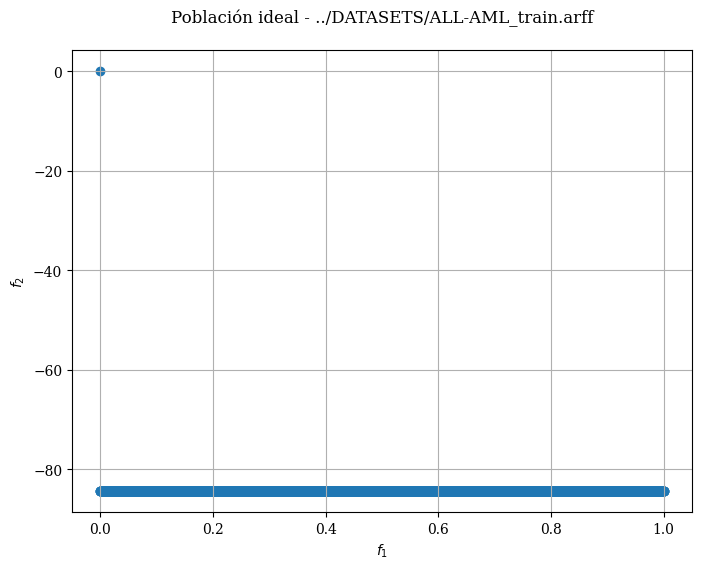

In [23]:
pf = problem.pareto_front()
print("Número de puntos de la población ideal ",DATASET_TRAIN_PATH," :",len(pf))    

title = "Población ideal - "+DATASET_TRAIN_PATH
VisualizacionPuntos(title,pf)

### Parámetros del algoritmo evolutivo

Hemos usado los siguientes parámetros para el algoritmo evolutivo NSGA-II:

- $G = 200$: Número de generaciones.
- $N = 50$: Tamaño de la población. En total $N \cdot G = 50 \cdot 200 = 10000$ evaluaciones de la función objetivo.
- $random\_state$: Semilla para reproducibilidad, que cambiaremos en cada prueba.
- $prob$: Probabilidades
- **Selección por ranking exponencial** con $c = 0.3$ y muestreo estocástico con reemplazamiento.
- **Cruce uniforme** con probabilidad $p_c = 0.6$.
- **Mutación bit-flip** con probabilidad $p_m = 0.1$.
- **Sustitución generacional completa**. Se generan $N$ hijos en cada generación y no se eliminan individuos duplicados.

A continuación se implementa esta configuración y describiremos cómo se ha conseguido.

In [24]:
N = pop_size
G = n_gen

random_state = SEED

p_c = 0.6 # Probabilidad de cruce

p_m = 0.1  # Probabilidad de mutación

EPS = 1e-7

amin = 0    # linear ranking
amax = 2-amin # linear ranking
q = 0.7 # non linear ranking
c = 0.3 # exponential ranking
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

In [25]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=bool)
        self.f2 = 0.0 # correlation-based score
        self.f1 = 1.0 # portion of selected features
    def __lt__(self, ind):
        # Orden lexicográfico
        if self.f1 < ind.f1:
            return True
        elif self.f1 > ind.f1:
            return False
        else:
            return self.f2 < ind.f2

In [26]:
def evaluate(I,f1, f2):           
    I.f1 = f1(I.x)
    I.f2 = f2(I.x)

In [27]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f1 = I2.f1
    I1.f2 = I2.f2   

In [28]:
amin = 0
amax = 2-amin
q = 0.7
c = 0.3
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

def calculate_cumulative_probabilities(cumulative_probabilities,P,N,param=param):
    amin,amax,q,c,rank_type = param    
    if rank_type == 'linear':
        cumulative_probabilities[0] = amax
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(amax+(amin-amax)*i/(N-1))/N
    if rank_type == 'nonlinear':   
        cumulative_probabilities[0] = q
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+q*(1-q)**i    
    if rank_type == 'exponential':
        den = c**N-1
        cumulative_probabilities[0] = (c-1)/den
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(c-1)*c**i/den
    return cumulative_probabilities

def cumulative_selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

La funciones auxiliares anteriores, del [notebook 9](https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Algoritmo%20evolutivo%20multi-many-objective%20_pymoo_.ipynb) de clase sirven para el cálculo de probabilidades acumuladas de cada puesto en el ranking. Usaremos solo el tipo de ranking exponencial.

In [29]:
def exp_probabilities(N,c):
    if N > 1:
        probs = c ** np.arange(N)
        probs *= (c-1) / (c ** N - 1)
        return probs
    else:
        return np.array([1.0])  

La función **exp_probabilities** es una forma de calcular la probabilidad individual de cada puesto en el ranking, para aprovechar directamente la función de muestreo con remplazo *np.random.choice*. A continuación implementamos el ranking exponencial con ordenación por no dominancia primero y distancia de crowding después.

In [30]:
INF_CROWDING_DISTANCE = 2*n_features # El máximo distancia de crowding (manhattan) es 1+\sqrt(n_features) < 2*n_features
def calc_crowding_distance(F):
    """
    Calcula la distancia de crowding para un conjunto de soluciones en el espacio de objetivos.

    Args:
        F (numpy.ndarray): Matriz de objetivos de tamaño (n_puntos, n_objetivos).

    Returns:
        numpy.ndarray: Vector con las distancias de crowding para cada solución.
    """
    n_points, n_obj = F.shape
    if n_points <= 2:
        # Si hay 2 o menos puntos, asignar distancia infinita
        return np.full(n_points, INF_CROWDING_DISTANCE)

    # Inicializar las distancias de crowding a cero
    distances = np.zeros(n_points)

    # Iterar sobre cada objetivo
    for i in range(n_obj):
        # Ordenar las soluciones según el objetivo i
        sorted_indices = np.argsort(F[:, i])
        sorted_F = F[sorted_indices, i]

        # Asignar distancia infinita a los extremos
        distances[sorted_indices[0]] += INF_CROWDING_DISTANCE
        distances[sorted_indices[-1]] += INF_CROWDING_DISTANCE

        # Calcular la distancia de crowding para los puntos intermedios
        for j in range(1, n_points - 1):
            if sorted_F[-1] - sorted_F[0] <= 0:  # Evitar división por cero
                continue
            distances[sorted_indices[j]] += (
                (sorted_F[j + 1] - sorted_F[j - 1]) / (sorted_F[-1] - sorted_F[0] + EPS)
            )

    return distances

    

La función **calc_crowding_distance** calcula la distancia de crowding de cada individuo en un mismo frente de dominación. La función devuelve un array con las distancias de crowding de cada individuo. Se calcula para cada individuo $x_i^t$ de la siguiente forma:

1. Previo: considerar el conjunto de individuos $\mathcal{D}_i$ con el mismo ranking de dominación que $x_i^t$. La función recibe una matriz de tamaño $n \times p$ con $n$ individuos y $p$ objetivos con los valores de $f_k$ para cada individuo del frente de dominación. En nuestro caso $p = 2$.
2. Para cada función objetivo $k = 1,\ldots, p$, ordenar la población en función de $f_k$ en una lista $l_k^i$.
3. Calcular la distancia $d_i$ como:
$$ d_i = \sum_{k=1}^{p}{\frac{f_k^{i+1} - f_k^{i-1}}{f_k^{\max}-f_k^{\min}}}, \forall i = 2, \ldots, n-1$$
4. Asignar distancia infinita a los extremos del frente $i = 1$ y $i = n$ en cada lista. En este caso, como el número de objetivos es 2 y su rango es $[0, -\sqrt{m}]$, la distancia infinita que hemos considerado es $d_\infty = 2m = 14258$.

In [31]:
def shuffle_inf_crowding(crowding, sorted_front):
    """Shuffle elements with distance >= INF_CROWDING_DISTANCE"""
    inf_front_indexes = np.where(crowding[sorted_front] >= INF_CROWDING_DISTANCE)[0]
    shuffled_indexes = np.random.permutation(inf_front_indexes)
    # Cambiar el orden de los índices
    sorted_front[inf_front_indexes] = sorted_front[shuffled_indexes]

class ExponentialDominanceSelection(Selection):
    def __init__(self, c=0.3):
        super().__init__()
        self.c = c
        self.param = amin,amax,q,c,'exponential'

    def _do(self, _, pop, n_select, n_parents, **kwargs):
        # Obtener el ranking de dominancia
        fronts = NonDominatedSorting().do(pop.get("F"), only_non_dominated_front=False)
        
        sorted_indices = []
        
        # Ordenar en cada frente por crowding distance
        for i, front in enumerate(fronts):
            # Calcular la distancia de crowding para cada frente
            crowding = calc_crowding_distance(pop.get("F")[front])
            # Ordenar nodos de forma decreciente por distancia de crowding
            sorted_front = np.argsort(-crowding)
            
            # Shuffle elements with distance >= INF_CROWDING_DISTANCE
            # Permutar aleatoriamente elementos con distancia de crowding máxima
            # (desempate para diversidad)
            if len(sorted_front) > 1:
                shuffle_inf_crowding(crowding, sorted_front)
            
            # Agregar índices ordenados al resultado
            for idx in sorted_front:
                sorted_indices.append(front[idx])
        
        # Seleccionar n_selected individuos basado en ranking exponencial
        probabilities = exp_probabilities(len(sorted_indices), self.c)
        selected_indices = np.random.choice(len(sorted_indices), size=n_select*n_parents, p=probabilities, replace=True)

        # Convertir a matriz de padres
        selected = selected_indices
        selected = selected.reshape((n_select, n_parents))
        return selected

# Construcción del algoritmo con selección personalizada
selector_exp = ExponentialDominanceSelection(c=0.3)

La clase **ExponentialDominanceSelection** implementa nuestra selección por ranking exponencial con ordenación por no dominancia primero y distancia de crowding después. Lo que hace para realizarlo es:
1. Ordenar la población por no dominancia, obteniendo varios frentes de dominación o conjuntos de individuos con mismo ranking de dominación.
2. Para cada frente de dominación, ordenar los individuos en orden decreciente por distancia de crowding. Además, como los primeros individuos de la lista siempre tienen distancia máxima, hemos decidido permutarlos aleatoriamente para evitar sesgos en la selección, rompiendo los empates aleatoriamente.
3. Calcular las probabilidades del ranking exponencial para cada individuo, usando la función *exp_probabilities*.
4. Seleccionar $N$ individuos de la población usando el muestreo estocástico con reemplazo de *np.random.choice*, usando las probabilidades calculadas en el paso anterior.

In [32]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

class CustomBinarySampling(Sampling):
        """Muestreo binario personalizado para la población inicial.
        Asegura que las primeras dos soluciones sean x = 0 (sin atributos seleccionados)
        y las dos últimas sean x = 1 (todos los atributos seleccionados),
        para garantizar cubrir los extremos del espacio de búsqueda.
        """
        def _do(self, problem, pop_size, **kwargs):
                # Crear una matriz de ceros para la población inicial
                samples = np.zeros((pop_size, problem.n_var), dtype=bool)
                
                # Garantizar que la primera solución sea x = 0 (sin atributos seleccionados)
                samples[:2, :] = 0
                samples[-2:, :] = 1  # Solución con todos los atributos seleccionados
                
                # Generar el resto de las soluciones aleatoriamente
                for i in range(2, pop_size-2):
                        sample = np.random.randint(0, 2, problem.n_var, dtype=bool)
                        samples[i, :] = sample

                return samples

def getAlgorithm(random_state, pop_size=pop_size, p_c=p_c, p_m=p_m, eliminate_duplicates=False,
                 sampling = CustomBinarySampling(), **kwargs):
        """
        Crea el algoritmo NSGA-II con los parámetros especificados.

        Args:
                random_state (int): Semilla para la aleatoriedad.
                pop_size (int): Tamaño de la población.
                p_c (float): Probabilidad de cruce.
                p_m (float): Probabilidad de mutación.
                eliminate_duplicates (bool): Si se deben eliminar duplicados.

        Returns:
                NSGA2: Instancia del algoritmo NSGA-II.
        """
        # Crear el algoritmo NSGA-II
        algorithm = NSGA2(
                        random_state=random_state,
                        pop_size=pop_size,
                        sampling=sampling,  # Muestreo binario personalizado
                        crossover=UniformCrossover(prob=p_c),  # Uniform crossover with p_c = 0.6
                        mutation=BitflipMutation(prob=p_m),    # Bit-flip mutation with p_m = 0.1
                        selection=selector_exp,  # Exponential ranking selection with c = 0.3
                        eliminate_duplicates=eliminate_duplicates,
                        n_offsprings=pop_size,
                        **kwargs)
        return algorithm

algorithm = getAlgorithm(random_state=SEED, pop_size=pop_size, p_c=p_c, p_m=p_m, eliminate_duplicates=False)

Aquí instanciamos nuestro algoritmo NSGA-II con los parámetros especificados. Creamos los componentes que faltaban:
- **Cruce uniforme**: pymoo.operators.crossover.ux.UniformCrossover
- **Mutación bit-flip**: pymoo.operators.mutation.bitflip.BitflipMutation
- **Sampling** inicial: hemos decidido siempre garantizar que haya dos individuos $x=0$ (ningún atributo seleccionado) y dos $x=1$ (todos los atributos seleccionados) en la población inicial para cubrir los dos extremos del espacio de búsqueda. El resto de individuos se generan con muestreo binario aleatorio con remplazamiento.

Especificamos los parámetros *n_offsprings*=N y *eliminate_duplicates*=False para garantizar sustitución generacional completa. El resto de parámetros son los que hemos definido antes.

## Ejecución de los experimentos

In [33]:
nadir = [1,0] # valores maximos [f1,f2]
ideal_point = [0,-np.sqrt(n_features)] # valores minimos [f1,f2]
max_area = abs((nadir[0] - ideal_point[0]) * (nadir[1] - ideal_point[1]))

print(f"Referencias para HV: ref_point={nadir}, ideal={ideal_point}, max_area={max_area}")

hv_indicator = HV(ref_point=nadir, ideal_point=ideal_point)

Referencias para HV: ref_point=[1, 0], ideal=[0, -84.43340571124678], max_area=84.43340571124678


In [34]:
STEP = n_gen // 8 if not profiling else 2*LEVEL

class SparseCallback(Callback):
    def __init__(self, step=STEP):
        super().__init__()
        self.step = step
        self.history = []

    def notify(self, algorithm):
        self.history.append({
            "gen" : algorithm.n_gen,
            "hv" : hv_indicator(algorithm.pop.get("F")),
        })
        if self.step < 0:
            return
        if algorithm.n_gen % self.step == 0:
            _hist, _callback, _display = algorithm.history, algorithm.callback, algorithm.display

            algorithm.history, algorithm.callback, algorithm.display = None, None, None
            obj = copy.deepcopy(algorithm)

            algorithm.history, algorithm.callback, algorithm.display = _hist, _callback, _display
            algorithm.history.append(obj)
    
    def reset(self):
        self.history = []
            
alg_callback = SparseCallback(step=STEP)
termination = get_termination("n_evals", n_gen*pop_size)

In [35]:
seed = SEED+0

if not DONE:
    print("Problema: ",DATASET_TRAIN_PATH)
    print("Algoritmo: NSGA2")
    start_time = time.time()
    res = minimize(problem=problem,
                    algorithm=algorithm,
                    termination=termination,
                    seed=seed,
                    save_history=False,
                    verbose=True,
                    callback=alg_callback)
    end_time = time.time()

    evolution_time = end_time - start_time
    print("Tiempo de ejecución: ", end_time - start_time)

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       50 |      3 |  0.000000E+00 |  0.0800000000 |  1.0330345549 |  0.4941191190 |  0.0029729248
     2 |      100 |      5 |  0.000000E+00 |  0.000000E+00 |  1.0340215413 |  0.4909868567 |  0.0029845015
     3 |      150 |      3 |  0.000000E+00 |  0.000000E+00 |  1.0335354848 |  0.4905665557 |  0.0030160982
     4 |      200 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0342708300 |  0.4879017519 |  0.0030358333
     5 |      250 |     10 |  0.000000E+00 |  0.000000E+00 |  1.0338880756 |  0.4882248286 |  0.0030549840
     6 |      300 |      3 |  0.000000E+00 |  0.000000E+00 |  1.0339050677 |  0.4859851428 |  0.0030553428
     7 |      350 |      4 |  0.000000E+00 |  0.000000E+00 |  1.0338115077 |  0.4867100359 |  0.0030593507
     8 |      400 |      5 |  0.000000E+00 |  0.000000E+00 |  1.0340654959 |  0.4846762849 |  0.0030665666
     9 |      450 |      2 |  0.00000

In [36]:
# Guardar resultados

results_pikle = os.path.join(RESULTS_DIR, "results-0.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-0.pkl")

if not LOAD:
    print("Resultados guardados en: ",results_pikle)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    with open(results_pikle, 'wb') as f:
        pickle.dump(res, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callback, f)

else:
    print("Resultados cargados de: ",results_pikle)
    with open(results_pikle, 'rb') as f:
        res = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callback = pickle.load(f)

Resultados guardados en:  cbio_p15_results/results-0.pkl


### Imprimir los valores de la solución y fitness

In [37]:
print("Problema",problem.name(),",",problem.n_obj," objetivos:")
print("Algoritmo",algorithm.__class__.__name__)
print("Solución: \nX = %s\nF = %s" % (res.X, res.F))
print("c = %s" % (np.sum(res.X, axis=1)))

Problema FeatureSelection , 2  objetivos:
Algoritmo NSGA2
Solución: 
X = [[False  True False ... False  True  True]
 [False  True False ... False  True  True]
 [False  True False ... False  True  True]
 ...
 [False  True False ... False  True  True]
 [False  True False ... False  True  True]
 [False  True False ... False  True  True]]
F = [[ 0.33048113 -0.6404655 ]
 [ 0.33118249 -0.64102375]
 [ 0.33062141 -0.64068356]
 [ 0.33076168 -0.64077913]
 [ 0.33090195 -0.64087103]
 [ 0.33104222 -0.64095458]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33118249 -0.64102375]
 [ 0.33118249 -0.64102375]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33118249 -0.64102375]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33048113 -0.6404655 ]
 [ 0.33118249 -0.64102375]
 [ 0.33118249 -0.64102375]
 [ 0.330481

### Visualización de las soluciones obtenidas y del frente de Pareto

In [38]:
# Visualizar frente de Pareto
def VisualizacionFrentePareto(title, res):
    if (len(res.F[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(res.F)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

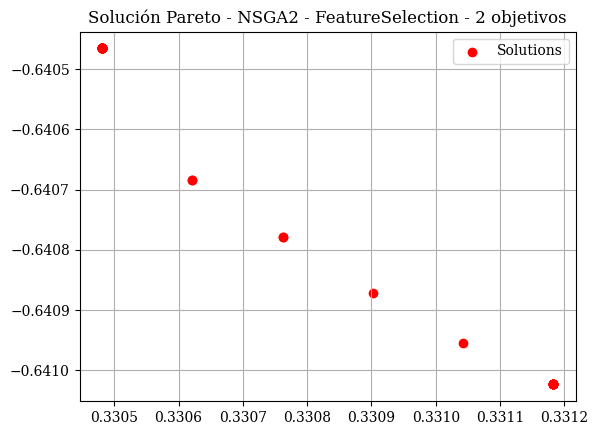

Individuos no dominados:  6
Individuo no dominado 0: 2356 features seleccionadas, f1 = 0.3305, f2 = -0.6405.
Individuo no dominado 1: 2361 features seleccionadas, f1 = 0.3312, f2 = -0.6410.
Individuo no dominado 2: 2357 features seleccionadas, f1 = 0.3306, f2 = -0.6407.
Individuo no dominado 3: 2358 features seleccionadas, f1 = 0.3308, f2 = -0.6408.
Individuo no dominado 4: 2359 features seleccionadas, f1 = 0.3309, f2 = -0.6409.
Individuo no dominado 5: 2360 features seleccionadas, f1 = 0.3310, f2 = -0.6410.


In [39]:
def VisualizacionSolucion(title,f):
    if (len(f[0])>2):
        VisualizacionPuntos(title,f)
        return
    
    fig, ax = plt.subplots()
    
    # Agregar las soluciones obtenidas
    x = [v[0] for v in f]
    y = [v[1] for v in f]
    ax.scatter(x, y, color='red', label='Solutions')

    # Mostrar el título
    plt.title(title)

    # Mostrar la leyenda
    plt.legend()    

    plt.grid(True)
    
    plt.show()
    
title = "Solución Pareto - "+algorithm.__class__.__name__ +" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos"
VisualizacionSolucion(title,res.F)

def get_unique_nds(res):
    """
    Obtiene las soluciones no dominadas únicas de un conjunto de soluciones.

    Args:
        res (pymoo.core.result.Result): Resultado de la optimización.

    Returns:
        list: Índices de las soluciones no dominadas únicas.
    """
    # Obtener el índice de las soluciones no dominadas
    nds = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
    
    # Eliminar soluciones duplicadas
    unique_nds_solutions = set()
    unique_nds_indexes = set()
    
    for i in range(len(nds)):
        s = tuple(res.F[nds[i]])
        if s not in unique_nds_solutions:
            unique_nds_solutions.add(s)
            unique_nds_indexes.add(nds[i])
    
    return list(unique_nds_indexes)

unique_nds_indexes = get_unique_nds(res)
        
print("Individuos no dominados: ",len(unique_nds_indexes))

for i,j in enumerate(unique_nds_indexes):
    s = res.F[j]
    c = np.sum(res.X[j])
    print(f"Individuo no dominado {i}: {c} features seleccionadas, f1 = {s[0]:.4f}, f2 = {s[1]:.4f}.")

### Indicadores de rendimiento

In [40]:
print("Base de datos:",DATASET_TRAIN_PATH)    
nadir = [1,0] # valores maximos [f1,f2]
maxArea = max_area
indicator = [
        GD(pf),
        GDPlus(pf),
        IGD(pf),
        IGDPlus(pf),
        hv_indicator
]
cadena = " \t \t "
print("NSGA2 \t \t \t ")
for iIndicator in range(len(indicator)):
    cadena = indicator[iIndicator].__class__.__name__+" \t "
    if (len(cadena)<10):
        cadena += " \t "
    cadena += str(indicator[iIndicator](res.F))+" \t "
    print(cadena)
cadena = "HV normalized \t "
cadena += str(indicator[len(indicator)-1](res.F)/maxArea)+" \t "
print(cadena)

Base de datos: ../DATASETS/ALL-AML_train.arff
NSGA2 	 	 	 
GD 	  	 0.7209024381014908 	 
GDPlus 	  	 0.33064384906719035 	 
IGD 	  	 83.78139831921116 	 
IGDPlus 	 83.78074842278934 	 
HV 	  	 0.4291773012484546 	 
HV normalized 	 0.005083027240618424 	 


### Visualización de la evolución de los algoritmos

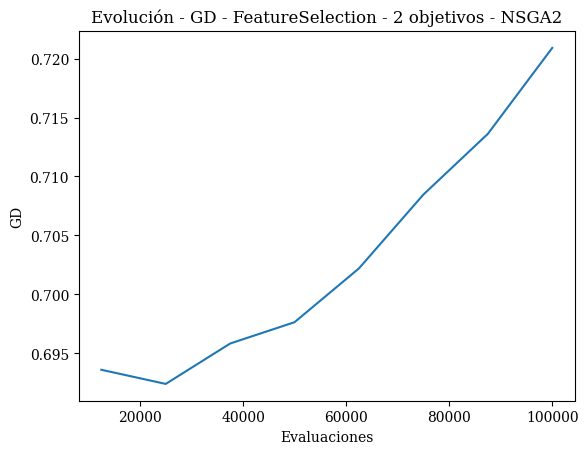

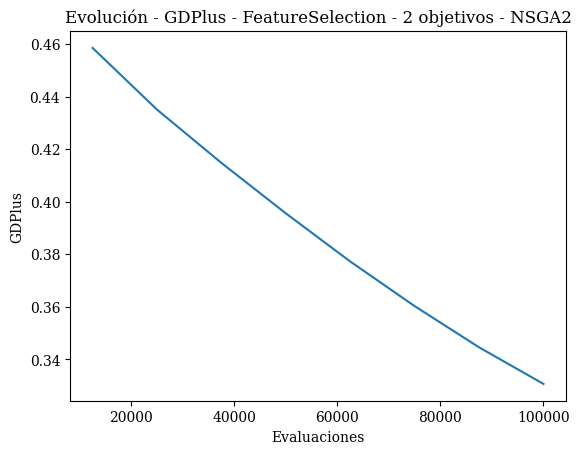

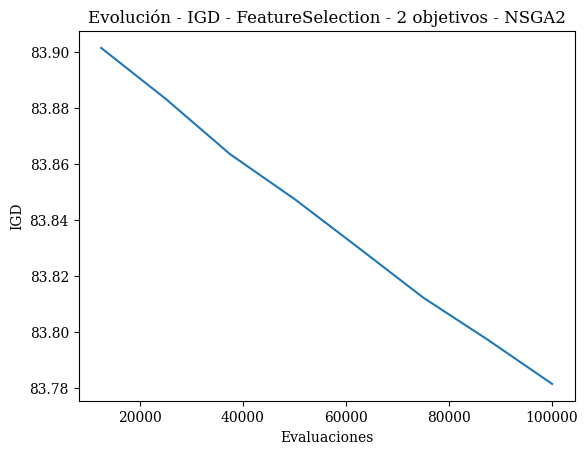

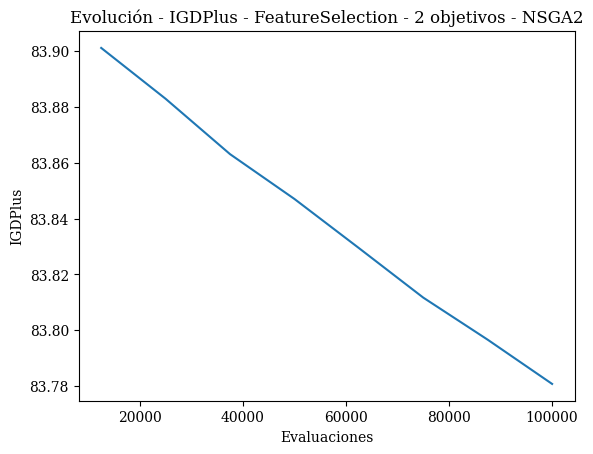

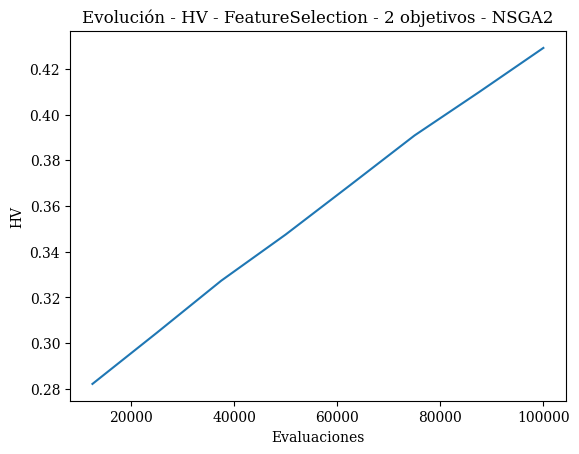

In [41]:
def VisualizacionEvolucion(title,res,values,yTitle):    
    n_evals = np.array([e.evaluator.n_eval for e in res.history]) # array con los números de evaluaciones
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 

for iIndicator in range(len(indicator)):
    values = np.array([indicator[iIndicator](e.opt.get("F")) for e in res.history])
    title = "Evolución - "+indicator[iIndicator].__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
    VisualizacionEvolucion(title,res,values,indicator[iIndicator].__class__.__name__)

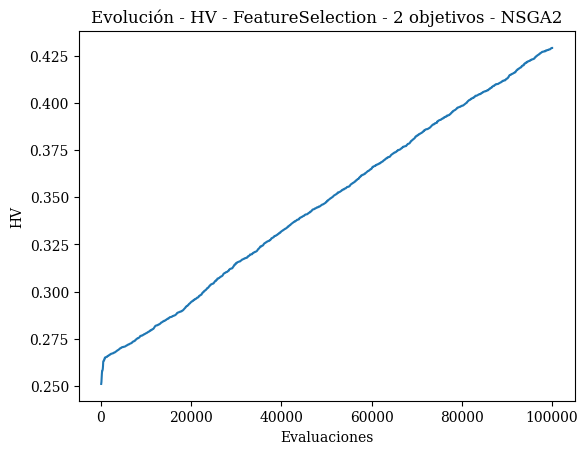

In [42]:
def VisualizacionEvolucionHV(title,n_evals,values,yTitle):    
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 


name = hv_indicator.__class__.__name__
ns_gen = np.array([e['gen'] for e in alg_callback.history])
n_evals = pop_size*ns_gen
values = np.array([e['hv'] for e in alg_callback.history])
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
VisualizacionEvolucionHV(title,n_evals,values,hv_indicator.__class__.__name__)

## Test con los modelos de clasificación

In [43]:
def getEstimators(random_state=None):
    estimators = [RandomForestClassifier(random_state=random_state), 
                SVC(random_state=random_state), 
                MLPClassifier(random_state=random_state)]
    return estimators

seed = SEED+0
estimators = getEstimators(random_state=seed)

# Guardar dataframe con columnas: seed, RF_train_acc, RF_test_acc, SVC_train_acc, SVC_test_acc, MLP_train_acc, MLP_test_acc

estimator_names = ['RF', 'SVC', 'MLP']
estimator_indexes = {name: i for i, name in enumerate(estimator_names)}

columns = ['seed', 'HV', 'time', 'nds']
for name in estimator_names:
    columns.append(name+'_train_acc')
for name in estimator_names:
    columns.append(name+'_test_acc')
for name in estimator_names:
    columns.append(name+'_val_acc')
for name in estimator_names:
    columns.append(name+'_c_features')

columns += ['c_min', 'c_max', 'f2_min', 'f2_max']

scores_dict0 = {col: [] for col in columns}

def add_results_to_dict(scores_dict, seed, hv, time, n_nds, train_scores, test_scores, val_scores,
                        c_features, c_min, c_max, f2_min, f2_max):
    # Agregar resultados al diccionario
    scores_dict['seed'].append(seed)
    scores_dict['HV'].append(hv)
    scores_dict['time'].append(time)
    scores_dict['nds'].append(n_nds)
    
    for i, name in enumerate(estimator_names):
        scores_dict[name+'_train_acc'].append(train_scores[i])
        scores_dict[name+'_test_acc'].append(test_scores[i])
        scores_dict[name+'_val_acc'].append(val_scores[i])
        scores_dict[name+'_c_features'].append(c_features[i])
    
    scores_dict['c_min'].append(c_min)
    scores_dict['c_max'].append(c_max)
    scores_dict['f2_min'].append(f2_min)
    scores_dict['f2_max'].append(f2_max)
    
    return scores_dict

def add_results_to_df(df, seed, hv, time, n_nds, train_scores, test_scores, val_scores,
                      c_features, c_min, c_max, f2_min, f2_max):
    # Crear un nuevo DataFrame con los resultados
    new_row = {
        'seed': seed,
        'HV': hv,
        'time': time,
        'nds': n_nds
    }
    
    for i, name in enumerate(estimator_names):
        new_row[name+'_train_acc'] = train_scores[i]
        new_row[name+'_test_acc'] = test_scores[i]
        new_row[name+'_val_acc'] = val_scores[i]
        new_row[name+'_c_features'] = c_features[i]
    
    new_row['c_min'] = c_min
    new_row['c_max'] = c_max
    new_row['f2_min'] = f2_min
    new_row['f2_max'] = f2_max
    
    # Concatenar el nuevo DataFrame al existente
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    return df

In [44]:
hv = hv_indicator(res.F)

nds = get_unique_nds(res) # Obtener soluciones no dominadas sin duplicados
nd_solutions = res.X[nds]
n_nds = len(nd_solutions)
print("Número de soluciones no dominadas: ",n_nds)

new_row = {
    'seed': seed,
    'HV': hv,
    'nds': n_nds,
}

c_min = np.sum(res.X[nds,:], axis=1).min()
c_max = np.sum(res.X[nds,:], axis=1).max()
f2_min = res.F[nds][:, 1].min()
f2_max = res.F[nds][:, 1].max()

train_scores = []
test_scores = []
val_scores = []
c_features = []

Número de soluciones no dominadas:  6


In [45]:
if not DONE:
    for estimator in estimators:
        j_max = 0
        val_max = -1
        
        print("Entrenando clasificador: ", estimator.__class__.__name__)
        for i, solution in enumerate(nd_solutions):
            n_selected = np.sum(solution)
            #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
            selected_features = np.where(solution == 1)[0]
            X = X_train.iloc[:, selected_features]

            val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
            mean_val_accuracy = np.mean(val_accuracy)
            if mean_val_accuracy > val_max:
                j_max = i
                val_max = mean_val_accuracy
        
        c = np.sum(nd_solutions[j_max])        
        print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", c, " features")
        c_features.append(c)
        
        selected_features = np.where(nd_solutions[j_max] == 1)[0]
        X = X_train.iloc[:, selected_features]
        estimator.fit(X, y_train)
        
        train_accuracy = estimator.score(X, y_train)
        test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
        val_accuracy = val_max
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        val_scores.append(val_accuracy)
        
        print(f"Validation accuracy: {val_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        print(f"Test accuracy: {test_accuracy}")
        
        print("----------------------")


    # Guardar resultados en el diccionario
    add_results_to_dict(scores_dict0, seed, hv, evolution_time, n_nds, train_scores, test_scores, val_scores, c_features,
                        c_min, c_max, f2_min, f2_max)

Entrenando clasificador:  RandomForestClassifier
Mejor solución:  0  con  0.9347222222222222 acc de validación y  2356  features
Validation accuracy: 0.9347222222222222
Train accuracy: 1.0
Test accuracy: 0.8235294117647058
----------------------
Entrenando clasificador:  SVC
Mejor solución:  0  con  0.8277777777777777 acc de validación y  2356  features
Validation accuracy: 0.8277777777777777
Train accuracy: 0.9473684210526315
Test accuracy: 0.8235294117647058
----------------------
Entrenando clasificador:  MLPClassifier
Mejor solución:  0  con  0.9722222222222222 acc de validación y  2356  features
Validation accuracy: 0.9722222222222222
Train accuracy: 0.9736842105263158
Test accuracy: 0.8823529411764706
----------------------


In [46]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-0.csv")

if not LOAD:
    df = pd.DataFrame(scores_dict0)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores)
    
    scores_dict = df.to_dict(orient='list')
    scores_df = pd.DataFrame(scores_dict)

In [47]:
display(scores_dict0)

{'seed': [2025],
 'HV': [0.4291773012484546],
 'time': [1219.7624979019165],
 'nds': [6],
 'RF_train_acc': [1.0],
 'SVC_train_acc': [0.9473684210526315],
 'MLP_train_acc': [0.9736842105263158],
 'RF_test_acc': [0.8235294117647058],
 'SVC_test_acc': [0.8235294117647058],
 'MLP_test_acc': [0.8823529411764706],
 'RF_val_acc': [0.9347222222222222],
 'SVC_val_acc': [0.8277777777777777],
 'MLP_val_acc': [0.9722222222222222],
 'RF_c_features': [2356],
 'SVC_c_features': [2356],
 'MLP_c_features': [2356],
 'c_min': [2356],
 'c_max': [2361],
 'f2_min': [-0.6410237472334557],
 'f2_max': [-0.6404654993275087]}

### Evaluar modelos con todas las features

In [48]:
if not DONE:
    estimators = getEstimators(random_state=SEED)
    for estimator in estimators:
        print(f"Entrenando clasificador: {estimator.__class__.__name__}")
        estimator.fit(X_train[:], y_train)
        
        train_accuracy = estimator.score(X_train[:], y_train)
        test_accuracy = estimator.score(X_test[:], y_test)
        
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        
        # K-fold CV Validation accuracy
        
        val_accuracy = cross_val_score(estimator, X_train[:], y_train, cv=cv)
        mean_val_accuracy = np.mean(val_accuracy)
        val_scores.append(mean_val_accuracy)
        
        print(f"Validation accuracy: {mean_val_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        print(f"Test accuracy: {test_accuracy}")

    scores_all_dict = {col: [] for col in columns}
    seed = SEED
    hv = 0
    
    n_nds = 1
    c_features = [n_features] * len(estimator_names)
    c_min = n_features
    c_max = n_features
    f2_min = problem.f2(np.ones(n_features), n_features)
    f2_max = f2_min
    
    # Agregar resultados al diccionario
    scores_all_dict = add_results_to_dict(scores_all_dict, seed, hv, 0, n_nds, train_scores, test_scores, val_scores,
                                          c_features, c_min, c_max, f2_min, f2_max)

Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.8666666666666667
Train accuracy: 1.0
Test accuracy: 0.7352941176470589
Entrenando clasificador: SVC
Validation accuracy: 0.7249999999999999
Train accuracy: 0.8157894736842105
Test accuracy: 0.6176470588235294
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.8791666666666667
Train accuracy: 0.9210526315789473
Test accuracy: 0.8529411764705882


In [49]:
# Guardar resultados

path_csv_scores_all = os.path.join(RESULTS_DIR, "scores-all.csv")
results_pikle_all = os.path.join(RESULTS_DIR, "results-all.pkl")
callbacks_pikle_all = os.path.join(RESULTS_DIR, "callbacks-all.pkl")

if not LOAD:
    df = pd.DataFrame(scores_all_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores_all)

    with open(results_pikle_all, 'wb') as f:
        pickle.dump(res, f)
    
    
    with open(callbacks_pikle_all, 'wb') as f:
        pickle.dump(alg_callback, f)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores_all)
    with open(results_pikle_all, 'rb') as f:
        res = pickle.load(f)
    
    with open(callbacks_pikle_all, 'rb') as f:
        alg_callback = pickle.load(f)
    
    scores_all_dict = df.to_dict(orient='list')
    scores_all_df = pd.DataFrame(scores_all_dict)

In [50]:
display(scores_all_dict)

{'seed': [2025],
 'HV': [0],
 'time': [0],
 'nds': [1],
 'RF_train_acc': [1.0],
 'SVC_train_acc': [0.9473684210526315],
 'MLP_train_acc': [0.9736842105263158],
 'RF_test_acc': [0.8235294117647058],
 'SVC_test_acc': [0.8235294117647058],
 'MLP_test_acc': [0.8823529411764706],
 'RF_val_acc': [0.9347222222222222],
 'SVC_val_acc': [0.8277777777777777],
 'MLP_val_acc': [0.9722222222222222],
 'RF_c_features': [7129],
 'SVC_c_features': [7129],
 'MLP_c_features': [7129],
 'c_min': [7129],
 'c_max': [7129],
 'f2_min': [0.48336417101746904],
 'f2_max': [0.48336417101746904]}

In [51]:
# Exclude 'HV' and 'time' columns from the DataFrame
exclude_columns = ['HV', 'time', 'nds', 'c_min', 'c_max', 'f2_max']
for e in estimator_names:
    exclude_columns.append(e+'_c_features')
df_all = pd.DataFrame({key: value for key, value in scores_all_dict.items() if key not in exclude_columns})
display(df_all)

seed  RF_train_acc  SVC_train_acc  MLP_train_acc  RF_test_acc  \
0  2025           1.0       0.947368       0.973684     0.823529   

   SVC_test_acc  MLP_test_acc  RF_val_acc  SVC_val_acc  MLP_val_acc    f2_min  
0      0.823529      0.882353    0.934722     0.827778     0.972222  0.483364

### Varias SEED

In [52]:
print("Problema: ",DATASET_TRAIN_PATH)
print("Algoritmo: NSGA2")

scores_dict = {col: [] for col in columns}
seeds = np.arange(SEED+1, SEED+11)
times = np.zeros((len(seeds),))
results = []
hvs = np.zeros((len(seeds),))

alg_callbacks = []
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        alg_callback = SparseCallback(step=-1)
        algorithm = getAlgorithm(random_state=random_state)
        start_time = time.time()
        
        res = minimize(problem=problem,
                        algorithm=algorithm,
                        termination=termination,
                        seed=random_state,
                        save_history=False,
                        verbose=True,
                        callback=alg_callback)
        
        end_time = time.time()
        
        evolution_time = end_time - start_time
        print(f"Tiempo de evolución: {evolution_time:.2f} segundos")
        
        hv = hv_indicator(res.F)
        
        results.append(res)
        alg_callbacks.append(alg_callback)
        times[t-1] = evolution_time
        hvs[t-1] = hv
       

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2
Ejecutando prueba 1 de 10
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       50 |      5 |  0.000000E+00 |  0.0800000000 |  1.0329268777 |  0.4954470012 |  0.0029851167
     2 |      100 |      7 |  0.000000E+00 |  0.000000E+00 |  1.0329265960 |  0.4940326598 |  0.0030187767
     3 |      150 |      6 |  0.000000E+00 |  0.000000E+00 |  1.0325406097 |  0.4918987860 |  0.0030385598
     4 |      200 |      6 |  0.000000E+00 |  0.000000E+00 |  1.0323059165 |  0.4932550519 |  0.0030496687
     5 |      250 |      5 |  0.000000E+00 |  0.000000E+00 |  1.0321196805 |  0.4934002104 |  0.0030711841
     6 |      300 |     19 |  0.000000E+00 |  0.000000E+00 |  1.0321194490 |  0.4873848644 |  0.0030715203
     7 |      350 |     15 |  0.000000E+00 |  0.000000E+00 |  1.0321029945 |  0.4931011008 |  0.0030726250
     8 |      400 |     10 |  0.000000E+00 |  0.000000E+00 

In [53]:
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        res = results[t-1]
        hv = hvs[t-1]
        evolution_time = times[t-1]
        
        nds = get_unique_nds(res) # Obtener soluciones no dominadas sin duplicados
        nd_solutions = res.X[nds]
        n_nds = len(nd_solutions)
        
        cs = np.sum(res.X[nds,:], axis=1)
        c_min = cs.min()
        c_max = cs.max()
        f2_min = res.F[nds][:, 1].min()
        f2_max = res.F[nds][:, 1].max()
        
        estimators = getEstimators(random_state=seed)
        train_scores = []
        test_scores = []
        val_scores = []
        c_features = []
        
        for estimator in estimators:
            j_max = 0
            val_max = -1
            print("Entrenando clasificador: ", estimator.__class__.__name__)
            for i, solution in enumerate(nd_solutions):
                n_selected = np.sum(solution)
                #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
                selected_features = np.where(solution == 1)[0]
                X = X_train.iloc[:, selected_features]

                val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
                mean_val_accuracy = np.mean(val_accuracy)
                if mean_val_accuracy > val_max:
                    j_max = i
                    val_max = mean_val_accuracy
            
            c = np.sum(nd_solutions[j_max])
            c_features.append(c)        
            print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", c, " features")
            
            selected_features = np.where(nd_solutions[j_max] == 1)[0]
            X = X_train.iloc[:, selected_features]
            estimator.fit(X, y_train)
            
            train_accuracy = estimator.score(X, y_train)
            test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
            val_accuracy = val_max
            
            train_scores.append(train_accuracy)
            test_scores.append(test_accuracy)
            val_scores.append(val_accuracy)
            
            print(f"Validation accuracy: {val_accuracy}")
            print(f"Train accuracy: {train_accuracy}")
            print(f"Test accuracy: {test_accuracy}")
            print("---------")
            print()
        add_results_to_dict(scores_dict, seed, hv, evolution_time, n_nds, train_scores, test_scores, val_scores,
                            c_features, c_min, c_max, f2_min, f2_max)
        

        print("--------------------")

Ejecutando prueba 1 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  0  con  0.9333333333333333 acc de validación y  2445  features
Validation accuracy: 0.9333333333333333
Train accuracy: 1.0
Test accuracy: 0.7352941176470589
---------

Entrenando clasificador:  SVC
Mejor solución:  0  con  0.8416666666666667 acc de validación y  2445  features
Validation accuracy: 0.8416666666666667
Train accuracy: 0.9736842105263158
Test accuracy: 0.8235294117647058
---------

Entrenando clasificador:  MLPClassifier
Mejor solución:  1  con  0.9722222222222222 acc de validación y  2444  features
Validation accuracy: 0.9722222222222222
Train accuracy: 1.0
Test accuracy: 0.9117647058823529
---------

--------------------
Ejecutando prueba 2 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  0  con  0.9208333333333333 acc de validación y  2430  features
Validation accuracy: 0.9208333333333333
Train accuracy: 1.0
Test accuracy: 0.8529411764705882
---------

Entr

In [54]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-10.csv")
results_pikle = os.path.join(RESULTS_DIR, "results-10.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-10.pkl")

if not LOAD:
    df = pd.DataFrame(scores_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)

    with open(results_pikle, 'wb') as f:
        pickle.dump(results, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callbacks, f)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores)
    with open(results_pikle, 'rb') as f:
        results = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callbacks = pickle.load(f)
    
    scores_dict = df.to_dict(orient='list')
    scores_df = pd.DataFrame(scores_dict)

In [55]:
display(scores_dict)

{'seed': [2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035],
 'HV': [0.4165984633357813,
  0.4081056815976644,
  0.41556606738131474,
  0.4205083760873678,
  0.42760655191811,
  0.41528719853720725,
  0.4153020503829642,
  0.42023280694914417,
  0.4096424441257429,
  0.4348963930679559],
 'time': [1251.8128762245178,
  1000.6475868225098,
  1208.993079662323,
  1314.0953614711761,
  1387.0488452911377,
  1374.2053399085999,
  1384.087013244629,
  1387.5145528316498,
  1549.457375049591,
  1446.0051543712616],
 'nds': [3, 2, 1, 5, 1, 4, 6, 6, 4, 4],
 'RF_train_acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'SVC_train_acc': [0.9736842105263158,
  0.9473684210526315,
  0.9210526315789473,
  0.9736842105263158,
  0.9736842105263158,
  0.9473684210526315,
  0.9736842105263158,
  0.9473684210526315,
  0.9473684210526315,
  0.9473684210526315],
 'MLP_train_acc': [1.0,
  1.0,
  0.9736842105263158,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'RF_test_acc': [0.735294

In [56]:
scores_df = pd.DataFrame(scores_dict)
scores_df

seed        HV         time  nds  RF_train_acc  SVC_train_acc  \
0  2026  0.416598  1251.812876    3           1.0       0.973684   
1  2027  0.408106  1000.647587    2           1.0       0.947368   
2  2028  0.415566  1208.993080    1           1.0       0.921053   
3  2029  0.420508  1314.095361    5           1.0       0.973684   
4  2030  0.427607  1387.048845    1           1.0       0.973684   
5  2031  0.415287  1374.205340    4           1.0       0.947368   
6  2032  0.415302  1384.087013    6           1.0       0.973684   
7  2033  0.420233  1387.514553    6           1.0       0.947368   
8  2034  0.409642  1549.457375    4           1.0       0.947368   
9  2035  0.434896  1446.005154    4           1.0       0.947368   

   MLP_train_acc  RF_test_acc  SVC_test_acc  MLP_test_acc  RF_val_acc  \
0       1.000000     0.735294      0.823529      0.911765    0.933333   
1       1.000000     0.852941      0.764706      0.911765    0.920833   
2       0.973684     0.764706      0.823529      0.852941    0.919444   
3       1.000000     0.852941      0.823529      0.941176    0.931944   
4       1.000000     0.852941      0.823529      0.911765    0.906944   
5       1.000000     0.764706      0.794118      0.941176    0.908333   
6       1.000000     0.823529      0.852941      0.911765    0.933333   
7       1.000000     0.764706      0.852941      0.941176    0.919444   
8       1.000000     0.823529      0.764706      0.941176    0.919444   
9       1.000000     0.764706      0.764706      0.941176    0.945833   

   SVC_val_acc  MLP_val_acc  RF_c_features  SVC_c_features  MLP_c_features  \
0     0.841667     0.972222           2445            2445            2444   
1     0.829167     1.000000           2430            2430            2430   
2     0.827778     0.933333           2425            2425            2425   
3     0.855556     1.000000           2354            2357            2354   
4     0.841667     0.950000           2345            2345            2345   
5     0.815278     0.962500           2407            2407            2411   
6     0.815278     0.973611           2397            2404            2402   
7     0.815278     0.973611           2431            2431            2433   
8     0.815278     0.958333           2446            2444            2444   
9     0.815278     1.000000           2288            2287            2285   

   c_min  c_max    f2_min    f2_max  
0   2442   2445 -0.633653 -0.633399  
1   2430   2431 -0.619150 -0.618519  
2   2425   2425 -0.629798 -0.629798  
3   2351   2357 -0.627419 -0.626217  
4   2345   2345 -0.637209 -0.637209  
5   2407   2411 -0.626976 -0.626791  
6   2397   2404 -0.625674 -0.625367  
7   2428   2434 -0.637278 -0.636414  
8   2441   2446 -0.622940 -0.622460  
9   2285   2288 -0.640045 -0.639792

In [57]:
# Reportar tabla con columnas: seed, hv, time, rf_train_acc, rf_test_acc, svc_train_acc, svc_test_acc, mlp_train_acc, mlp_test_acc
# añadir filas adicionales: mejor, peor, media y desviación típica

# Crear un nuevo DataFrame con los resultados
summary_dict = {}
summary_dict['seed'] = ['best', 'worst', 'mean', 'std']

hvs = scores_df['HV'].to_numpy()
summary_dict['HV'] = [np.max(hvs), np.min(hvs), np.mean(hvs), np.std(hvs)]

times = scores_df['time'].to_numpy()
summary_dict['time'] = [np.min(times), np.max(times), np.mean(times), np.std(times)]

for metric in ['train_acc', 'test_acc', 'c_features']:
    for i, name in enumerate(estimator_names):
        metric_name = f"{name}_{metric}"
        metric_values = scores_df[metric_name].to_numpy()
        if metric != 'c_features':
            summary_dict[metric_name] = [np.max(metric_values), np.min(metric_values), np.mean(metric_values), np.std(metric_values)]
        else:
            summary_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

for m1 in ['c', 'f2']:
    for m2 in ['min', 'max']: 
        metric_name = f"{m1}_{m2}"
        metric_values = scores_df[metric_name].to_numpy()
        summary_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

summary_df = pd.DataFrame(summary_dict)
summary_df = summary_df.set_index('seed')
# renombrar columna seed a stat
summary_df = summary_df.rename_axis('stat')

display(summary_df)


HV         time  RF_train_acc  SVC_train_acc  MLP_train_acc  \
stat                                                                       
best   0.434896  1000.647587           1.0       0.973684       1.000000   
worst  0.408106  1549.457375           1.0       0.921053       0.973684   
mean   0.418375  1330.386718           1.0       0.955263       0.997368   
std    0.007602   142.316943           0.0       0.016850       0.007895   

       RF_test_acc  SVC_test_acc  MLP_test_acc  RF_c_features  SVC_c_features  \
stat                                                                            
best      0.852941      0.852941      0.941176    2288.000000     2287.000000   
worst     0.735294      0.764706      0.852941    2446.000000     2445.000000   
mean      0.800000      0.808824      0.920588    2396.800000     2397.500000   
std       0.043226      0.032883      0.026471      49.262156       49.084111   

       MLP_c_features        c_min        c_max    f2_min    f2_max  
stat                                                                 
best      2285.000000  2285.000000  2288.000000 -0.640045 -0.639792  
worst     2444.000000  2442.000000  2446.000000 -0.619150 -0.618519  
mean      2397.300000  2395.100000  2398.600000 -0.630014 -0.629597  
std         49.904008    49.216765    49.414977  0.006491  0.006586

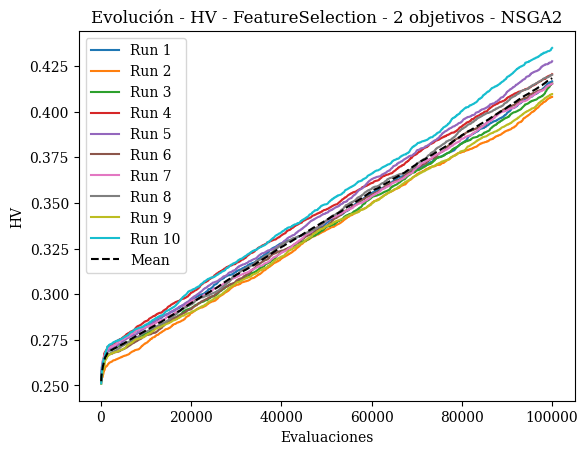

In [58]:
fig, ax = plt.subplots()
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 

ax.set_title(title)
plt.xlabel("Evaluaciones")
yTitle = hv_indicator.__class__.__name__
plt.ylabel(yTitle)

n_evals_mean = np.zeros((len(alg_callback.history),))
values_mean = np.zeros((len(alg_callback.history),))

for i, alg_callback in enumerate(alg_callbacks):
    ns_gen = np.array([e['gen'] for e in alg_callback.history])
    n_evals = pop_size*ns_gen
    values = np.array([e['hv'] for e in alg_callback.history])
    plt.plot(n_evals, values, label=f"Run {i+1}")
    
    n_evals_mean += n_evals
    values_mean += values
n_evals_mean = n_evals_mean/len(alg_callbacks)
values_mean = values_mean/len(alg_callbacks)
plt.plot(n_evals_mean, values_mean, label="Mean", color='black', linestyle='--')

plt.legend()
plt.show() 

In [59]:
scores_df.describe()

seed         HV         time        nds  RF_train_acc  \
count    10.00000  10.000000    10.000000  10.000000          10.0   
mean   2030.50000   0.418375  1330.386718   3.600000           1.0   
std       3.02765   0.008013   150.015230   1.837873           0.0   
min    2026.00000   0.408106  1000.647587   1.000000           1.0   
25%    2028.25000   0.415291  1267.383498   2.250000           1.0   
50%    2030.50000   0.416082  1379.146177   4.000000           1.0   
75%    2032.75000   0.420439  1387.398126   4.750000           1.0   
max    2035.00000   0.434896  1549.457375   6.000000           1.0   

       SVC_train_acc  MLP_train_acc  RF_test_acc  SVC_test_acc  MLP_test_acc  \
count      10.000000      10.000000    10.000000     10.000000     10.000000   
mean        0.955263       0.997368     0.800000      0.808824      0.920588   
std         0.017762       0.008322     0.045565      0.034662      0.027902   
min         0.921053       0.973684     0.735294      0.764706      0.852941   
25%         0.947368       1.000000     0.764706      0.772059      0.911765   
50%         0.947368       1.000000     0.794118      0.823529      0.926471   
75%         0.973684       1.000000     0.845588      0.823529      0.941176   
max         0.973684       1.000000     0.852941      0.852941      0.941176   

       RF_val_acc  SVC_val_acc  MLP_val_acc  RF_c_features  SVC_c_features  \
count   10.000000    10.000000    10.000000      10.000000       10.000000   
mean     0.923889     0.827222     0.972361    2396.800000     2397.500000   
std      0.012122     0.014672     0.022637      51.926872       51.739196   
min      0.906944     0.815278     0.933333    2288.000000     2287.000000   
25%      0.919444     0.815278     0.959375    2364.750000     2368.750000   
50%      0.920139     0.821528     0.972917    2416.000000     2416.000000   
75%      0.932986     0.838542     0.993403    2430.750000     2430.750000   
max      0.945833     0.855556     1.000000    2446.000000     2445.000000   

       MLP_c_features        c_min       c_max     f2_min     f2_max  
count       10.000000    10.000000    10.00000  10.000000  10.000000  
mean      2397.300000  2395.100000  2398.60000  -0.630014  -0.629597  
std         52.603443    51.879026    52.08796   0.006842   0.006942  
min       2285.000000  2285.000000  2288.00000  -0.640045  -0.639792  
25%       2366.000000  2362.500000  2368.75000  -0.636320  -0.635660  
50%       2418.000000  2416.000000  2418.00000  -0.628609  -0.628294  
75%       2432.250000  2429.500000  2433.25000  -0.626000  -0.625580  
max       2444.000000  2442.000000  2446.00000  -0.619150  -0.618519

## 7. Conclusiones


## Referencias

1. Jiménez Barrionuevo, F., & Sánchez Carpena, G. (2025). Computación Bio-inspirada. Tema 5: Algoritmos bio-inspirados para machine learning. Máster en Inteligencia Artificial, Universidad de Murcia. Departamento de Ingeniería de la Información y las Comunicaciones. Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20Diapositivas%20de%20clase/Tema5.pdf
2. pymoo documentation. pymoo: Multi-objective Optimization in Python. Disponible en: https://pymoo.org (Accedido el 21 de abril de 2025).
3. Hall, M. A. (1999). Correlation-based feature selection for discrete and numeric class machine learning. In Proceedings of the 17th International Conference on Machine Learning (ICML-2000) (pp. 359-366). Morgan Kaufmann. Disponible en https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=0e78b20b27d27261f9ae088eb13201f2d5b185bd (Accedido el 21 de abril de 2025).
4. Selección de atributos evolutiva multi-objetivo para clasificación (pymoo), Jupyter Notebook.
Fernando Jiménez Barrionuevo y Gracia Sánchez Carpena. Notebook 16 de clase de Computación Bio-inspirada, Máster en Inteligencia Artificial, Universidad de Murcia, 2025.
Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Selección%20de%20atributos%20evolutiva%20multi-objetivo%20para%20clasificación%20_pymoo_.ipynb​
5. Algoritmo evolutivo multi-many-objective (pymoo), Jupyter Notebook.
Fernando Jiménez Barrionuevo y Gracia Sánchez Carpena. Notebook 9 de clase de Computación Bio-inspirada, Máster en Inteligencia Artificial, Universidad de Murcia, 2025.
Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Algoritmo%20evolutivo%20multi-many-objective%20_pymoo_.ipynb

## Contribución de cada miembro del grupo

- Santiago Méndez García:
 
- Domingo Méndez García: 
  - Presentación oral.